In [2]:
import os
import sys
import time
import shutil
import logging
import argparse
import yaml
import traceback
import math


import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import ConcatDataset

In [8]:
sys.path.append(os.path.join(os.path.abspath(os.path.join(os.getcwd(), '..'))))
sys.path.append(os.path.join(os.path.abspath(os.path.join(os.getcwd(), '..')), 'src'))

In [9]:
from flows.models.maf import MAF

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [11]:
sys.path

['/Users/jaron/Projects/f-dre/notebooks',
 '/Users/jaron/opt/anaconda3/envs/f-dre/lib/python38.zip',
 '/Users/jaron/opt/anaconda3/envs/f-dre/lib/python3.8',
 '/Users/jaron/opt/anaconda3/envs/f-dre/lib/python3.8/lib-dynload',
 '',
 '/Users/jaron/opt/anaconda3/envs/f-dre/lib/python3.8/site-packages',
 '/Users/jaron/Projects/f-dre',
 '/Users/jaron/Projects/f-dre',
 '/Users/jaron/Projects/f-dre',
 '/Users/jaron/Projects/f-dre/src']

In [12]:
from classification.models.mlp import MLPClassifier, MLPClassifierv2
from classification.models.flow_mlp import FlowClassifier
import argparse
import yaml

# Helper functions

In [13]:
def logsumexp_1p(s):
    # numerically stable implementation of log sigmoid via logsumexp
    # NOTE: this assumes that you feed in -s for the positive probabilities
    if len(s.size()) == 2:
        s = s.squeeze()
    x = torch.stack([s, torch.zeros_like(s)], -1)
    val, _ = torch.max(x, 1)
    val = val.repeat(2,1).T
    logsigmoid = torch.clamp(s, 0) + torch.log(
        torch.sum(torch.exp(x - val), 1))

    return -logsigmoid

In [14]:

def dict2namespace(config):
    namespace = argparse.Namespace()
    if isinstance(config, list):
        # from creating config files
        for i in range(len(config)):
            for key, value in config[i].items():
                if isinstance(value, dict):
                    new_value = dict2namespace(value)
                else:
                    new_value = value
                setattr(namespace, key, new_value)
    else:
        # vanilla training
        for key, value in config.items():
            if isinstance(value, dict):
                new_value = dict2namespace(value)
            else:
                new_value = value
            setattr(namespace, key, new_value)
    return namespace

In [15]:


def get_optimizer(config, parameters):
    if config.optim.optimizer == 'Adam':
        return optim.Adam(parameters, lr=config.optim.lr, weight_decay=config.optim.weight_decay,
            betas=(config.optim.beta1, 0.999), amsgrad=config.optim.amsgrad,
            eps=config.optim.eps)
    elif config.optim.optimizer == 'RMSProp':
        return optim.RMSprop(parameters, lr=config.optim.lr, weight_decay=config.optim.weight_decay)
    elif config.optim.optimizer == 'SGD':
        return optim.SGD(parameters, lr=config.optim.lr, momentum=0.9)
    else:
        raise NotImplementedError(
            'Optimizer {} not understood.'.format(config.optim.optimizer))
        
@torch.no_grad()
def test(model, dataloader, epoch, args, device):
    model.eval()
    logprobs = []

    # unconditional model
    for data in dataloader:

        if len(data) == 1:
            x, y = data[0], None
        else:
            x, y = data
            y = y.to(device)
        x = x.to(device).view(x.shape[0], -1)
        log_px = model.module.log_prob(x)
        logprobs.append(log_px)
    logprobs = torch.cat(logprobs, dim=0).to(device)

    logprob_mean, logprob_std = logprobs.mean(0), 2 * logprobs.var(0).sqrt() / math.sqrt(len(dataloader.dataset))
    output = 'Evaluate ' + (epoch != None)*'(epoch {}) -- '.format(epoch) + 'logp(x) = {:.3f} +/- {:.3f}'.format(logprob_mean, logprob_std)
    print(output)
    results_file = os.path.join(args.out_dir, 'results.txt')
    print(output, file=open(results_file, 'a'))
    return logprob_mean, logprob_std

def get_model(config):
    return MAF(config.model.n_blocks, config.model.input_size, config.model.hidden_size, config.model.n_hidden, None, 
                config.model.activation_fn, config.model.input_order, batch_norm=not config.model.no_batch_norm)
    
def train(args, config, dataloaders, device):
    train_dataloader, val_dataloader, test_dataloader = dataloaders 
    
    model = get_model(config)
          
    model = model.to(device)


    optimizer = get_optimizer(config, model.parameters())

    start_epoch, step = 0, 0
    best_eval_logprob = float('-inf')
    if args.resume_training:
        print('restoring checkpoint from {}'.format(args.restore_file))
        state = torch.load(os.path.join(args.restore_file, "best_model_checkpoint.pt"), map_location=device)
        model.load_state_dict(state['model_state'])
        optimizer.load_state_dict(state['optimizer_state'])
        start_epoch = state['epoch'] + 1
    model = torch.nn.DataParallel(model)

    # Training loop
    for epoch in range(start_epoch, config.training.n_epochs):
        data_start = time.time()
        data_time = 0
        # original maf code
        for i, data in enumerate(train_dataloader):
            
            
            # Sets model in training mode
            model.train()
            step += 1

            # check if labeled dataset
            if len(data) == 1:
                x, y = data[0], None
            else:
                x, y = data
                y = y.to(device)
            x = x.view(x.shape[0], -1).to(device)
            
            # Evaluate loss
            loss = -model.module.log_prob(x, y=None).mean(0)
            
            # Compute gradients
            loss.backward()
            optimizer.step()
            
            # Zero gradients
            optimizer.zero_grad()

            if i % config.training.log_interval == 0:
                print('epoch {:3d} / {}, step {:4d} / {}; loss {:.4f}'.format(
                    epoch, start_epoch + config.training.n_epochs, i, len(train_dataloader), loss.item()))

            data_start = time.time()

        # now evaluate and save metrics/checkpoints
        eval_logprob, _ = test(
            model, test_dataloader, epoch, args, device)

        torch.save({
            'epoch': epoch,
            'model_state': model.module.state_dict(),
            'optimizer_state': optimizer.state_dict()},
            os.path.join(args.out_dir, 'model_checkpoint.pt'))
        # save model only
        torch.save(
            model.state_dict(), os.path.join(
                args.out_dir, 'model_state.pt'))
        # save best state
        if eval_logprob > best_eval_logprob:
            best_eval_logprob = eval_logprob
            print('saving model at epoch {}'.format(epoch))
            torch.save({
                'epoch': epoch,
                'model_state': model.module.state_dict(),
                'optimizer_state': optimizer.state_dict()},
                os.path.join(args.out_dir, 'best_model_checkpoint.pt'))
            # generate samples
#             self.visualize(self.args, model, epoch)

In [16]:
class Gaussian(Dataset):
    def __init__(self, args, config, typ, split='train'):
        self.args = args
        self.config = config
        self.split = split
        self.type = typ
        assert self.type in ['bias', 'ref']

        self.p_mu = self.config.data.mus[0]
        self.q_mu = self.config.data.mus[1]

        self.perc = config.data.perc
        self.input_size = config.data.input_size
        self.label_size = 1
        self.base_dist = Normal(self.config.data.mus[0], 1)  # bias
        
        ### ADD HOTFIX
        try:
            fpath = os.path.join(self.config.training.data_dir, 'gmm')
            data = np.load(os.path.join(fpath, 'gmm_p{}_q{}.npz'.format(self.p_mu, self.q_mu)))
        except FileNotFoundError:
            if not os.path.exists(fpath):
                os.makedirs(fpath)
            data = self.generate_data()

        if self.type == 'bias':
            data = data['p']
        else:
            data = data['q']

        # train/val/test split
        if split == 'train':
            data = data[0:40000]
        elif split == 'val':
            data = data[40000:45000]
        else:
            data = data[45000:]
        if self.type == 'ref' and self.split != 'val':  # keep val same
            to_keep = int(len(data) * self.perc)
            data = data[0:to_keep]
        self.data = torch.from_numpy(data).float()

    def generate_data(self):
        p = np.random.randn(50000,2) + self.p_mu
        q = np.random.randn(50000,2) + self.q_mu
        np.savez(os.path.join(self.config.training.data_dir, 'gmm', 'gmm_p{}_q{}.npz'.format(self.p_mu, self.q_mu)), **{
            'p': p,
            'q': q
        })
        return {'p': p, 'q': q}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        item = self.data[i]
        if self.type == 'bias':
            label = torch.zeros(1)
        else:
            label = torch.ones(1)

        return item, label


In [17]:
def get_dataloaders(args, config, device):
    pass

def get_gaussian_dataloaders(args, config, device):
    
    print("Getting dataloaders")
    input_dims = 2
    label_size = 1
    lam = 1e-6
    batch_size = config.training.batch_size
    
    train_biased = Gaussian(args, config, 'bias', split='train')
    val_biased = Gaussian(args, config, 'bias', split='val')
    test_biased = Gaussian(args, config, 'bias', split='test')

    train_ref = Gaussian(args, config, 'ref', split='train')
    val_ref = Gaussian(args, config, 'ref', split='val')
    test_ref = Gaussian(args, config, 'ref', split='test')

    if args.encode_z:
        # keep each dataset separate for encoding
        for dataset in (train_biased, train_ref):
            dataset.input_dims = input_dims
            dataset.input_size = int(np.prod(input_dims))
            dataset.label_size = label_size

        kwargs = {'num_workers': 1, 'pin_memory': True} if device.type == 'cuda' else {}

        train_loader_biased = DataLoader(train_biased, batch_size, shuffle=True, **kwargs)
        val_loader_biased = DataLoader(val_biased, batch_size, shuffle=False, **kwargs)
        test_loader_biased = DataLoader(test_biased, batch_size, shuffle=False, **kwargs)
        train_loader_ref = DataLoader(train_ref, batch_size, shuffle=True, **kwargs)
        val_loader_ref = DataLoader(val_ref, batch_size, shuffle=False, **kwargs)
        test_loader_ref = DataLoader(test_ref, batch_size, shuffle=False, **kwargs)

        return [train_loader_biased, train_loader_ref], [val_loader_biased, val_loader_ref], [test_loader_biased, test_loader_ref]

    train_dataset = ConcatDataset([train_biased, train_ref])
    val_dataset = ConcatDataset([val_biased, val_ref])
    test_dataset = ConcatDataset([test_biased, test_ref])
    
    train_dataset.input_dims = input_dims
    train_dataset.input_size = int(np.prod(input_dims))
    train_dataset.label_size = label_size
    train_dataset.lam = lam

    test_dataset.input_dims = input_dims
    test_dataset.input_size = int(np.prod(input_dims))
    test_dataset.label_size = label_size
    test_dataset.lam = lam

    if val_dataset is not None:
        val_dataset.input_dims = input_dims
        val_dataset.input_size = int(np.prod(input_dims))
        val_dataset.label_size = label_size
        val_dataset.lam = lam

    # construct dataloaders
    kwargs = {'num_workers': 1, 'pin_memory': True} if device.type == 'cuda' else {}

    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, **kwargs)
    val_loader = DataLoader(val_dataset, batch_size, shuffle=False, **kwargs) if val_dataset is not None else None
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False, **kwargs)
    
    return train_loader, val_loader, test_loader

# Get args and config

In [71]:
def set_up_args_and_configs():
    args = {'config': '/Users/jaron/Projects/f-dre/src/configs/flows/gmm/maf_copy.yaml',
           'exp_id': 'gmm_flow_exp', 
           'resume_training': False,
           'restore_file': False,
           'seed': 1234, 
           'encode_z': False}
    args = dict2namespace(args)
    with open(os.path.join('configs', args.config), 'r') as f:
        config = yaml.safe_load(f)
    new_config = dict2namespace(config)
    
    args.out_dir = os.path.join(new_config.training.out_dir, args.exp_id)
    print(os.path.exists(args.out_dir))
    if not os.path.exists(args.out_dir):
        print(args.out_dir)
        os.makedirs(args.out_dir, exist_ok=True)
    args.log_path = os.path.join(args.out_dir, 'logs')
    os.makedirs(args.out_dir, exist_ok=True)
    
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(args.seed)
        
    return args, new_config

In [72]:
args, config = set_up_args_and_configs()

True


In [73]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Run training

In [74]:
dataloaders = get_gaussian_dataloaders(args, config, device)

Getting dataloaders


In [75]:
dataloaders


(<torch.utils.data.dataloader.DataLoader at 0x7f8a588baa30>,
 <torch.utils.data.dataloader.DataLoader at 0x7f8a588bad90>)

In [76]:
train(args, config, dataloaders, device)

epoch   0 / 100, step    0 / 800; loss 4.0832
epoch   0 / 100, step  500 / 800; loss 3.6061
Evaluate (epoch 0) -- logp(x) = -3.498 +/- 0.019
saving model at epoch 0
epoch   1 / 100, step    0 / 800; loss 3.5299
epoch   1 / 100, step  500 / 800; loss 3.5893
Evaluate (epoch 1) -- logp(x) = -3.509 +/- 0.019
epoch   2 / 100, step    0 / 800; loss 3.5287
epoch   2 / 100, step  500 / 800; loss 3.5536
Evaluate (epoch 2) -- logp(x) = -3.492 +/- 0.019
saving model at epoch 2
epoch   3 / 100, step    0 / 800; loss 3.4646
epoch   3 / 100, step  500 / 800; loss 3.4975
Evaluate (epoch 3) -- logp(x) = -3.498 +/- 0.018
epoch   4 / 100, step    0 / 800; loss 3.4104
epoch   4 / 100, step  500 / 800; loss 3.4310
Evaluate (epoch 4) -- logp(x) = -3.497 +/- 0.019
epoch   5 / 100, step    0 / 800; loss 3.4249
epoch   5 / 100, step  500 / 800; loss 3.4406
Evaluate (epoch 5) -- logp(x) = -3.496 +/- 0.019
epoch   6 / 100, step    0 / 800; loss 3.5525
epoch   6 / 100, step  500 / 800; loss 3.3852
Evaluate (epoc

Evaluate (epoch 56) -- logp(x) = -3.490 +/- 0.020
epoch  57 / 100, step    0 / 800; loss 3.5094
epoch  57 / 100, step  500 / 800; loss 3.3981
Evaluate (epoch 57) -- logp(x) = -3.487 +/- 0.019
saving model at epoch 57
epoch  58 / 100, step    0 / 800; loss 3.4685
epoch  58 / 100, step  500 / 800; loss 3.5293
Evaluate (epoch 58) -- logp(x) = -3.489 +/- 0.019
epoch  59 / 100, step    0 / 800; loss 3.7048
epoch  59 / 100, step  500 / 800; loss 3.5029
Evaluate (epoch 59) -- logp(x) = -3.489 +/- 0.019
epoch  60 / 100, step    0 / 800; loss 3.3791
epoch  60 / 100, step  500 / 800; loss 3.2195
Evaluate (epoch 60) -- logp(x) = -3.488 +/- 0.019
epoch  61 / 100, step    0 / 800; loss 3.4480
epoch  61 / 100, step  500 / 800; loss 3.2875
Evaluate (epoch 61) -- logp(x) = -3.489 +/- 0.019
epoch  62 / 100, step    0 / 800; loss 3.4536
epoch  62 / 100, step  500 / 800; loss 3.5067
Evaluate (epoch 62) -- logp(x) = -3.490 +/- 0.020
epoch  63 / 100, step    0 / 800; loss 3.3615
epoch  63 / 100, step  500 

# Dataset

In [77]:
import torch
from torch.distributions import Normal

In [78]:
p = Normal(0, 1)
q = Normal(3, 1)

In [79]:
px = p.sample((2000,2))
qx = q.sample((2000,2))

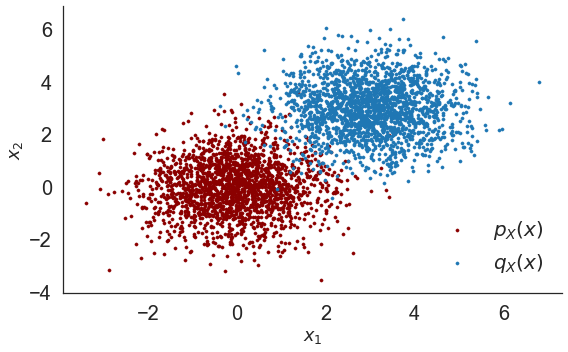

In [80]:
plt.figure(figsize=(8,5))
plt.scatter(px[:,0], px[:,1], label=r'$p_X(x)$', s=10, color='darkred')
plt.scatter(qx[:,0], qx[:,1], label=r'$q_X(x)$', s=10, color='tab:blue')

plt.legend(loc='lower right', fontsize=20)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
sns.despine()

In [81]:
true_xs = torch.cat([px, qx])
true_xs.shape

torch.Size([4000, 2])

In [82]:
true_ratios = torch.exp((q.log_prob(true_xs).sum(-1) - p.log_prob(true_xs).sum(-1)))
true_log_r = torch.log(true_ratios)

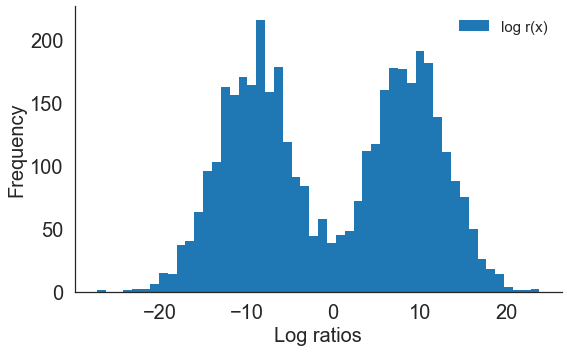

In [83]:
plt.figure(figsize=(8,5))
_ = plt.hist(true_log_r.data.cpu().numpy(), bins=50, label='log r(x)')
# plt.title('True log ratios')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)

plt.ylabel('Frequency', fontsize=20)
plt.xlabel('Log ratios', fontsize=20)
sns.despine()
plt.tight_layout()

------

# Z-Space

In [95]:
device = 'cpu'

In [96]:
# with open(os.path.join('configs/classification/gmm/mlp_z.yaml'), 'r') as f:
#     config = yaml.safe_load(f)
# new_config = dict2namespace(config)

In [97]:
# z_mlp = MLPClassifierv2(new_config)
# restore_file = 'classification/results/gmm_z/checkpoints/model_best.pth'
# state = torch.load(restore_file, map_location='cpu')
# z_mlp.load_state_dict(state['state_dict'])
# z_mlp = z_mlp.to(device)

In [102]:
# load flow
import os
from flows.models.maf import MAF

# model = MAF(5, 
#             2, 
#             100, 
#             1, 
#             None, 
#             'relu', 
#             'sequential', 
#             batch_norm=True)
model = get_model(config)
restore_file = '/Users/jaron/Projects/f-dre/src/flows/results/gmm_flow_exp/'
state = torch.load(os.path.join(restore_file, "best_model_checkpoint.pt"), map_location='cpu')
model.load_state_dict(state['model_state'])
model = model.to(device)
model.eval()

MAF(
  (net): FlowSequential(
    (0): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      )
    )
    (1): BatchNorm()
    (2): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      )
    )
    (3): BatchNorm()
    (4): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      

# Get encoded vectors

In [103]:
# get dres
z, _ = model.forward(true_xs.cpu())
#logits, probas = z_mlp(z.cpu())
#z_log_ratios = (logsumexp_1p(-logits) - logsumexp_1p(logits)).squeeze()

In [104]:
z

tensor([[-0.4269,  0.7236],
        [-0.2447,  0.2601],
        [-1.1686, -0.6138],
        ...,
        [ 1.5062, -2.1610],
        [ 0.4861,  1.1167],
        [ 0.5751,  1.1846]], grad_fn=<AddBackward0>)